In [54]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from xgboost import XGBClassifier
import xgboost as xgb

from sklearn.model_selection import KFold, cross_val_score, train_test_split, cross_validate, GridSearchCV
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import average_precision_score

## Load Data

In [55]:
data = pd.read_csv('data/conversion_data.csv')
data.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


In [56]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316200 entries, 0 to 316199
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   country              316200 non-null  object
 1   age                  316200 non-null  int64 
 2   new_user             316200 non-null  int64 
 3   source               316200 non-null  object
 4   total_pages_visited  316200 non-null  int64 
 5   converted            316200 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 14.5+ MB


In [57]:
data.describe()

,age,new_user,total_pages_visited,converted
count,316200.000000,316200.000000,316200.000000,316200.000000
mean,30.569858,0.685465,4.872966,0.032258
std,8.271802,0.464331,3.341104,0.176685
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,123.000000,1.000000,29.000000,1.000000


In [58]:
#check for missing values
data.isnull().any()

country                False
age                    False
new_user               False
source                 False
total_pages_visited    False
converted              False
dtype: bool

No missing values

In [59]:
for column in data.columns:
    print(column,"\t",data[column].unique())

country 	 ['UK' 'US' 'China' 'Germany']
age 	 [ 25  23  28  39  30  31  27  29  38  43  24  36  37  33  20  35  17  50
  22  18  34  19  42  32  21  48  40  41  26  45  44  49  46  56  52  54
  51  47  53  60  57  55  59  61  58  62  65  63  66  67  64  68  69 123
  70  73  77  72  79 111]
new_user 	 [1 0]
source 	 ['Ads' 'Seo' 'Direct']
total_pages_visited 	 [ 1  5  4  6  2  8  7  3  9 14 10 11 18 15 19 12 13 21 17 23 16 25 26 20
 22 24 27 28 29]
converted 	 [0 1]


Observations:

1. country and source is categorical with 4 and 3 distinct categories respectively
2. new_user and converted are binary
3. There are some outliers in age (age should be less than 100). We can either remove the values or replace them with some central tendancy. If there are less outliers, we will remove them, else replace them.

In [60]:
data[data['age']>100]

,country,age,new_user,source,total_pages_visited,converted
90928,Germany,123,0,Seo,15,1
295581,UK,111,0,Ads,10,1


Since there are only two, we can remove them. 

In [61]:
#if we wanted to substitute with the mean:
# data.loc[data['age']>100, "age"] = int(data.age.mean())

data = data[data['age']<100]

## Exploratory Data Analysis

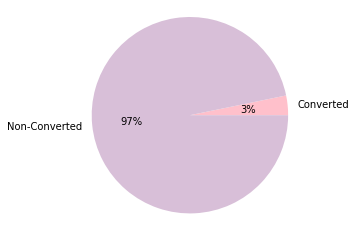

In [62]:
#checking distribution of "converted"

%matplotlib inline

labels=["Converted", "Non-Converted"]
sizes=[data['converted'].value_counts()[1],
     data['converted'].value_counts()[0]]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels,autopct='%1.0f%%', colors = ['pink','thistle'])
ax1.axis('equal')
plt.show()

Thus, the dataset is extremely imbalanced

### Country 

In [63]:
#country stats

countries = data[['country', 'converted']].groupby('country').mean().reset_index()
countries

,country,converted
0,China,0.001332
1,Germany,0.062428
2,UK,0.052612
3,US,0.037801


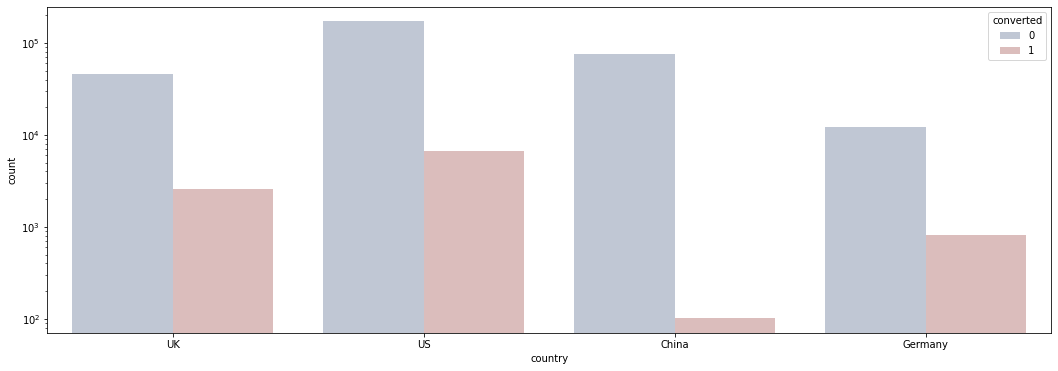

In [64]:
#Count plot (Population) per country
fig, ax = plt.subplots(figsize=(18, 6))
sns.countplot(x='country', hue='converted',data=data, ax=ax, palette="vlag")
ax.set_yscale('log') #scaling because of the huge difference between converted and non converted counts
plt.show()

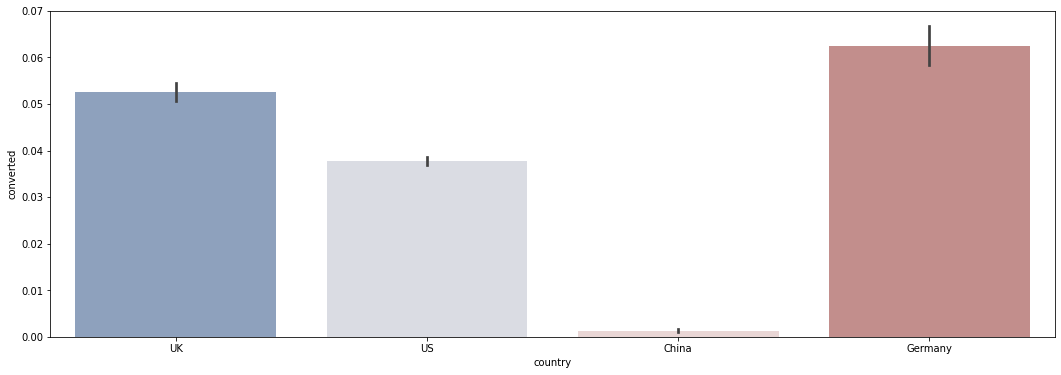

In [65]:
#Mean Conversion per country
fig, ax = plt.subplots(figsize=(18, 6))
sns.barplot(x='country', y='converted', data=data, ax=ax, palette="vlag")
plt.show()

Observations:
1. US has a high population and good conversion rate
2. China has a high population but low conversion rate
3. Germany has a very high conversion rate for its small population. Likewise with UK

### Age

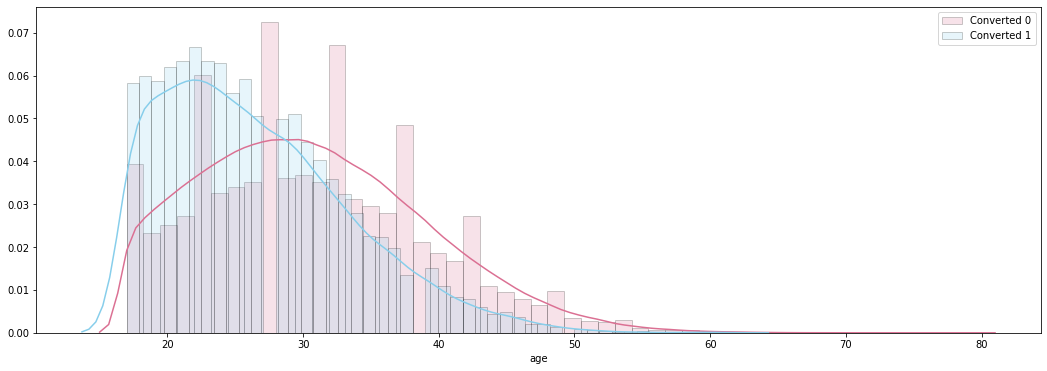

In [66]:
#Count plot
hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}

fig, ax = plt.subplots(figsize=(18, 6))
sns.distplot(data[data['converted'] == 0]['age'], label='Converted 0', 
             ax=ax, hist_kws=hist_kws, color = 'palevioletred')
sns.distplot(data[data['converted'] == 1]['age'], label='Converted 1', 
             ax=ax, hist_kws=hist_kws, color = 'skyblue')
ax.legend()

Text(0.5, 0, 'age')

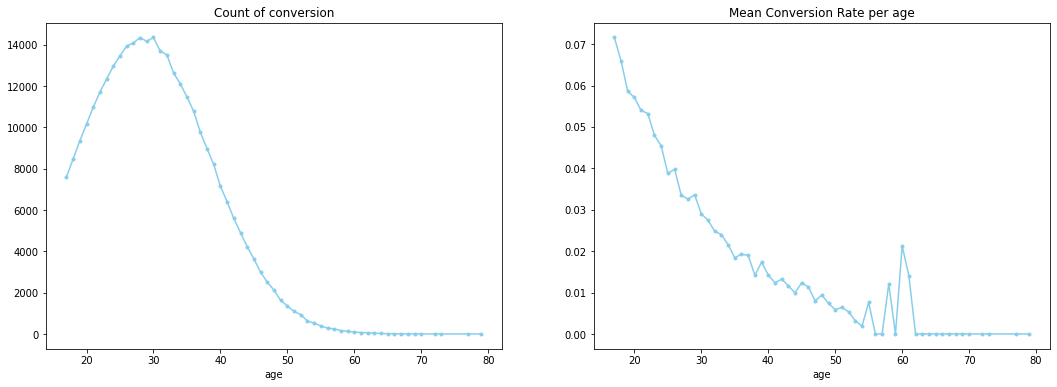

In [67]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

ax[0].plot(data[['age', 'converted']].groupby(['age']).agg(['count']), '.-', color = 'skyblue')
ax[0].set_title('Count of conversion')
ax[0].set_xlabel('age')

ax[1].plot(data[['age', 'converted']].groupby(['age']).agg(['mean']), '.-', color = 'skyblue')
ax[1].set_title('Mean Conversion Rate per age')
ax[1].set_xlabel('age')

Younger users seem to be buying more frequently. There is almost 0 cinversion for customers over the age of 60

### User Type (new vs old)

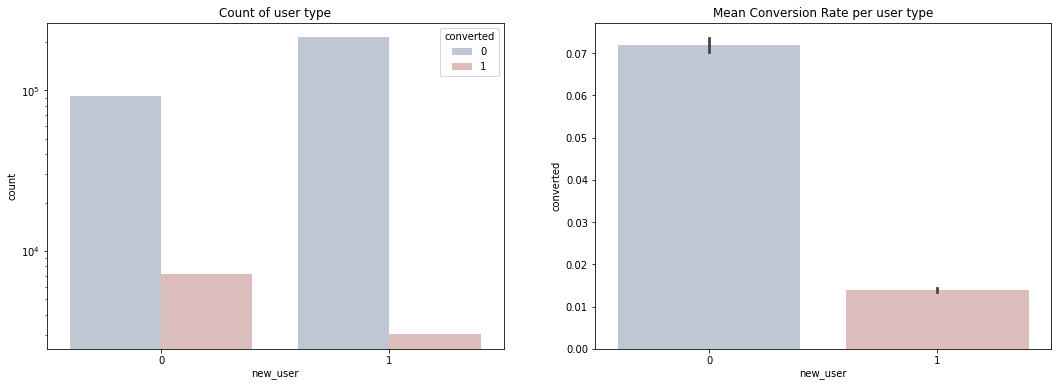

In [68]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(18, 6))
sns.countplot(x='new_user', hue='converted', data=data, ax=ax[0], palette="vlag")
ax[0].set_title('Count of user type')
ax[0].set_yscale('log') #scaling because of the huge difference between converted and non converted counts

sns.barplot(x='new_user', y='converted', data=data, ax=ax[1], palette="vlag")
ax[1].set_title('Mean Conversion Rate per user type')
plt.show()

New users do not convert as much

### Source

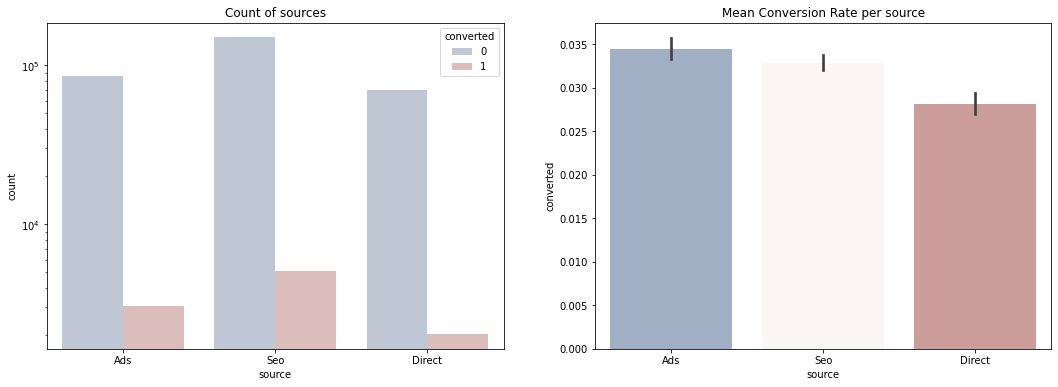

In [69]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(18, 6))
sns.countplot(x='source', hue='converted', data=data, ax=ax[0], palette="vlag")
ax[0].set_title('Count of sources')
ax[0].set_yscale('log') #scaling because of the huge difference between converted and non converted counts

sns.barplot(x='source', y='converted', data=data, ax=ax[1], palette="vlag")
ax[1].set_title('Mean Conversion Rate per source')
plt.show()

Mean conversion rates per sources are nearly the same.

### Number of pages visited

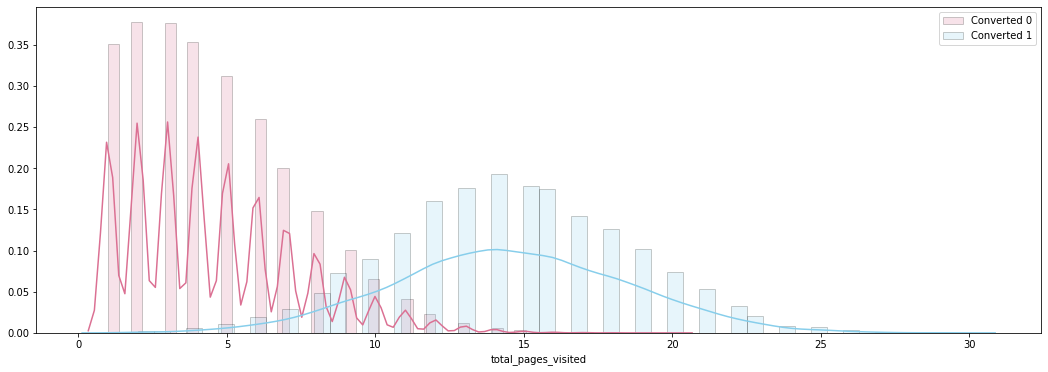

In [70]:
fig, ax = plt.subplots(figsize=(18, 6))
sns.distplot(data[data['converted'] == 0]['total_pages_visited'], label='Converted 0', 
             ax=ax, hist_kws=hist_kws, color = 'palevioletred')
sns.distplot(data[data['converted'] == 1]['total_pages_visited'], label='Converted 1', 
             ax=ax, hist_kws=hist_kws, color = 'skyblue')
ax.legend()

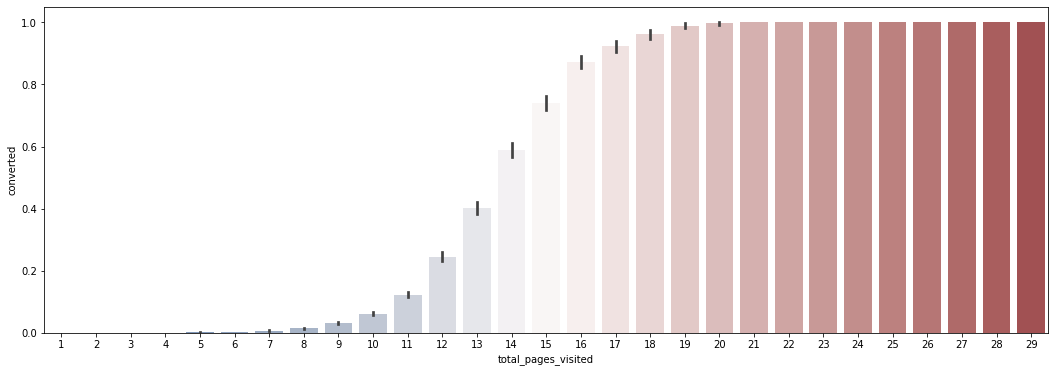

In [71]:
fig, ax = plt.subplots(figsize=(18, 6))
sns.barplot(x='total_pages_visited', y='converted', data=data, ax=ax, palette="vlag")
plt.show()

The more times a user visits a page, the more likely he is to buy something.

## Model 

In [72]:
#convert into categorical features with pd.get_dummies()

data = pd.get_dummies(data)
data.head()

,age,new_user,total_pages_visited,converted,country_China,country_Germany,country_UK,country_US,source_Ads,source_Direct,source_Seo
0,25,1,1,0,0,0,1,0,1,0,0
1,23,1,5,0,0,0,0,1,0,0,1
2,28,1,4,0,0,0,0,1,0,0,1
3,39,1,5,0,1,0,0,0,0,0,1
4,30,1,6,0,0,0,0,1,0,0,1


In [73]:
#check column type
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 316198 entries, 0 to 316199
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype
---  ------               --------------   -----
 0   age                  316198 non-null  int64
 1   new_user             316198 non-null  int64
 2   total_pages_visited  316198 non-null  int64
 3   converted            316198 non-null  int64
 4   country_China        316198 non-null  uint8
 5   country_Germany      316198 non-null  uint8
 6   country_UK           316198 non-null  uint8
 7   country_US           316198 non-null  uint8
 8   source_Ads           316198 non-null  uint8
 9   source_Direct        316198 non-null  uint8
 10  source_Seo           316198 non-null  uint8
dtypes: int64(4), uint8(7)
memory usage: 24.2 MB


Creating training and test sets. Using k-fold validation to obtain 4 training and 1 test set.

In [74]:
#need a numpy array for the XGBoost model
y = data['converted'].values
x = data.drop('converted', axis = 1).values
#y

In [75]:
kf = KFold(n_splits=5, shuffle=True, random_state=2)

In [76]:
model = XGBClassifier()

In [77]:
accuracies=[]
precisions=[]
importances=[]

for train, test in kf.split(x):
    prediction = model.fit(x[train], y[train]).predict(x[test])
    accuracies.append(accuracy_score(y[test], prediction))
    precisions.append(average_precision_score(y[test], prediction))
    importances.append(model.feature_importances_.tolist())
    
print('Average Accuracy: ' + str(np.array(accuracies).mean()))
print('Average Precision: ' +  str(np.array(precisions).mean()))

Average Accuracy: 0.9859518393915779
Average Precision: 0.5929970567970446


<AxesSubplot:>

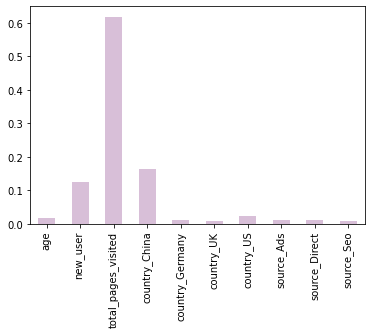

In [78]:
avg_importance = map(np.mean, zip(*importances))
features = data.drop("converted", axis=1).columns.values
pd.Series(model.feature_importances_, index=features).plot(kind='bar', color="thistle")

Thus, the most important feature is the total_pages_visited, while source isn't as important (this is seen in EDA as well). 

While total_pages_visited seems like the most important factor, we really cannot control it. 

<AxesSubplot:>

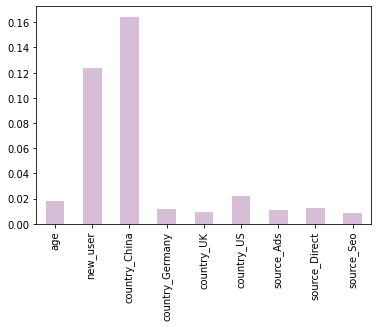

In [79]:
features = data.drop(["total_pages_visited","converted"], axis=1).columns.values
new=np.delete(model.feature_importances_, 2)
pd.Series(new, index=features).plot(kind='bar', color="thistle")

We see that China has a terrible conversion rate and thus plays a huge role in the model. new_user also plays a good role, but ot cannot be controlled.